### Questions 
 - What time of the day do I listen? [ok]
 - Day of the week [ok]
 - Hours per day [ok]
 - Time of day vs day of week [ok]
 - Weekend vs non weekend (duration and time of day)
 - From SearchQueries, when do I usually search? Is it on Fridays? Not enough search data.
 - How much overlap between my library and streaming history?
 - Which songs to I come back to over larger periods of time?
 - Which songs I listened to a lot and then forgot about it?
 - How many tracks per artist? (Do I listen to full albums a lot?)

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
import os

sns.set_context("talk", font_scale=1)
sns.set_style("darkgrid")
sns.set_color_codes()

In [2]:
# list available data
os.listdir('./data/')

['YourLibrary.json',
 'Userdata.json',
 'Playlist.json',
 'Payments.json',
 'StreamingHistory.json',
 'SearchQueries.json',
 'Follow.json',
 'FamilyPlan.json']

In [50]:
# import track library and 90 day streaming history
# convert to dataframe
with open('./data/YourLibrary.json') as f:
    tracks_df = pd.DataFrame(json.load(f)['tracks'])

with open('./data/StreamingHistory.json') as f:
    history_df = pd.DataFrame(json.load(f))
    
with open('./data/SearchQueries.json') as f:
    search_df = pd.DataFrame(json.load(f))

In [4]:
# check columns and dtypes

In [5]:
print(history_df.dtypes)
print()
print(tracks_df.dtypes)

artistName    object
endTime       object
msPlayed       int64
trackName     object
dtype: object

album     object
artist    object
track     object
dtype: object


## Processing date time

In [6]:
# the time is in string format
history_df['endTime'].values

array(['2018-10-11 04:37', '2018-10-11 04:39', '2018-10-11 04:41', ...,
       '2019-01-09 20:37', '2019-01-09 20:43', '2019-01-09 20:47'],
      dtype=object)

In [53]:
# convert endTime strings to datetime format
history_df['endTime']=pd.to_datetime(history_df['endTime'])
# convert time to minutes
history_df['minPlayed'] = history_df['msPlayed']/1000/60
history_df.drop('msPlayed', axis=1, inplace=True)

### Fix timezone and DST issues

In [54]:
# daylight savings ends
dst = pd.datetime(2018,11,11,2,0,0)
# Wyoming trip
wyo_i = pd.datetime(2018,10,20)
wyo_f = pd.datetime(2018,10,23)

# Colorado trip
col_i = pd.datetime(2018,12,20)
col_f = pd.datetime(2018,12,28)

In [55]:
# make copy of endTime
dt = history_df['endTime'].copy()
# shift to GMT -5
dt -= pd.Timedelta(value='5h')
# add one hour during daylight saving time
dt[dt < dst] += pd.Timedelta(value='1h')
# subtract two hours for both GMT -7 trips
dt[(dt >= wyo_i) & (dt <= wyo_f)] -= pd.Timedelta(value='2h')
dt[(dt >= col_i) & (dt <= col_f)] -= pd.Timedelta(value='2h')

# implement adjustments
history_df['endTime'] = dt

In [56]:
# get some dedicated datetime columns
history_df['dayOfWeek'] = history_df['endTime'].dt.day_name()
history_df['dayOfMonth'] = history_df['endTime'].dt.day
history_df['timeOfDay'] = history_df['endTime'].dt.hour
history_df['date'] = history_df['endTime'].dt.date

## Streaming stats

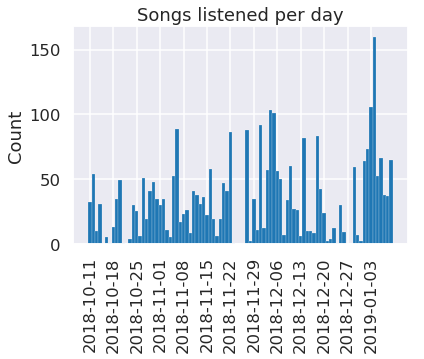

In [57]:
x = history_df.groupby('date').size().index
y = history_df.groupby('date').size().values
xticks = pd.date_range(x[0],x[-1]).date[::7]
plt.bar(x,y, width=1, linewidth=0.2)
ax = plt.gca()
#space parameter by week
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.tick_params('x', rotation=90)
ax.set_ylabel('Count')
ax.set_title('Songs listened per day')
plt.show()

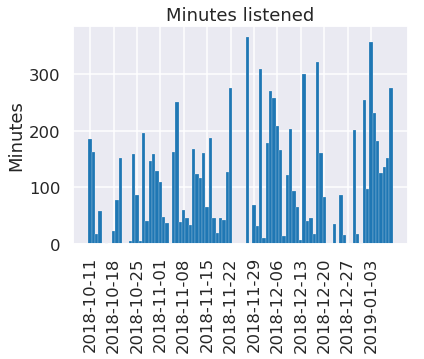

In [58]:
mindata = history_df.groupby('date')['minPlayed'].sum()
x, y = mindata.index, mindata.values

xticks = pd.date_range(x[0],x[-1]).date[::7]
plt.bar(x,y, width=1, linewidth=0.2)
ax = plt.gca()
#space parameter by week
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.tick_params('x', rotation=90)
ax.set_ylabel('Minutes')
ax.set_title('Minutes listened')
plt.show()

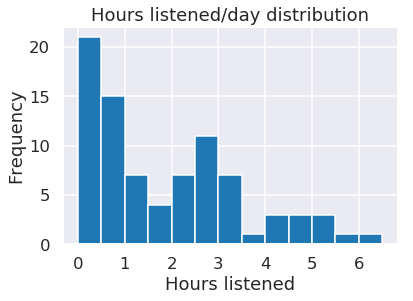

In [59]:
h = y/60
hbins = np.arange(0,np.ceil(h.max()),0.5)
plt.hist(h,hbins)
plt.xticks(hbins[::2])
plt.xlabel('Hours listened')
plt.ylabel('Frequency')
plt.title('Hours listened/day distribution')
plt.show()

### Listening frequency per time of day
In this case at first I naively grouped by timeOfDay and took the mean. However when you do that you fail to account for the times you were simply not listening to music, so you average the listening time of when you're listening which turns out is fairly uniform accross the day. Instead, to compare listening frequency you should go either by counts or total minutes listened for each hour.

Text(0.5, 0, 'Time of day')

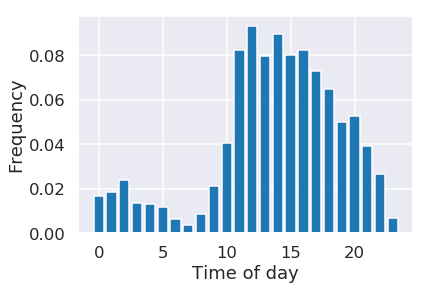

In [60]:
data = history_df.groupby('timeOfDay')['minPlayed'].sum()
x, y = data.index, data.values
plt.bar(x,y/y.sum())
plt.ylabel('Frequency')
plt.xlabel('Time of day')

### How long are the songs?

Text(0, 0.5, 'Frequency')

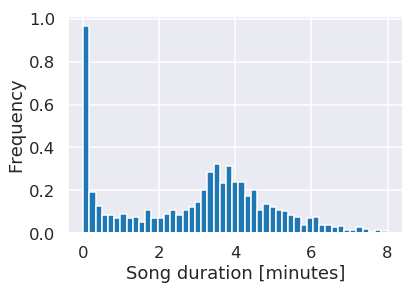

In [61]:
plt.hist(history_df.minPlayed, bins = np.linspace(0,8,50),
        density=True);
plt.xlabel('Song duration [minutes]')
plt.ylabel('Frequency')

In [62]:
history_df.columns

Index(['artistName', 'endTime', 'trackName', 'minPlayed', 'dayOfWeek',
       'dayOfMonth', 'timeOfDay', 'date'],
      dtype='object')

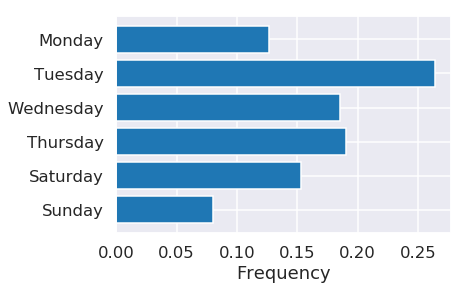

In [63]:
data = history_df.groupby('dayOfWeek')['minPlayed'].sum()
data = data[[1,5,6,4,2,3]][::-1]
x, y = data.index, data.values
plt.barh(x,y/y.sum())
plt.xlabel('Frequency')
plt.show()

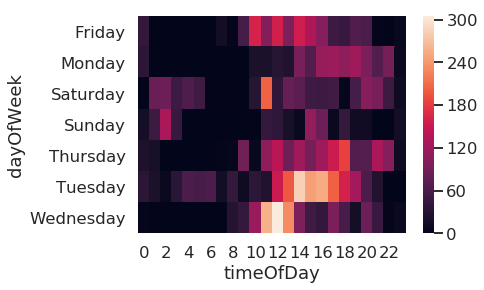

In [19]:
timevsweek = history_df.pivot_table(columns='timeOfDay', index='dayOfWeek', 
                                             values='minPlayed', aggfunc=np.sum).fillna(0)
sns.heatmap(timevsweek)


### Comparing with library
 - How many of the listened tracks are in my library?
 - When do I listen to new music and when do I listen to saved music?

In [20]:
# checking whether or not it is in my library
history_df['inLibrary'] = 0
for i in history_df.index:
    if history_df.loc[i,'trackName'] in tracks_df.track.values:
        history_df.loc[i,'inLibrary'] = 1

In [39]:
##################################

Text(0, 0.5, 'Artist')

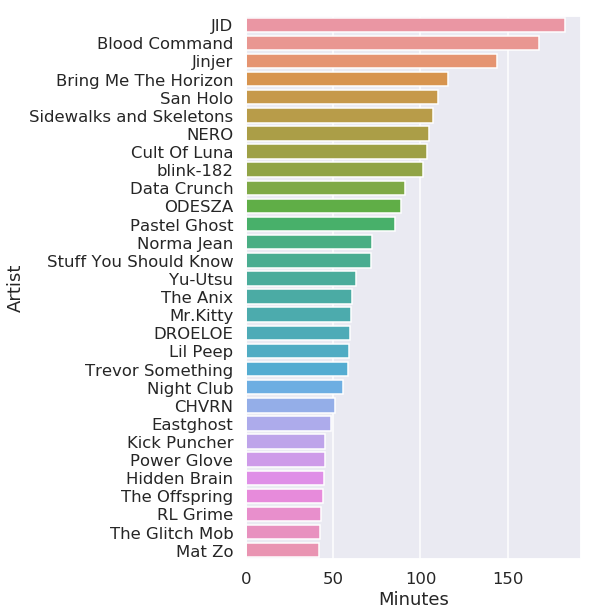

In [23]:
fig = plt.figure(figsize=(6,10))
ax = plt.subplot(111)
data = history_df.groupby('artistName')['minPlayed'].sum().sort_values(ascending=False)[:30]
x = data.index
y = data.values
sns.barplot(y,x, orient="h", ax = ax)
ax.set_xlabel('Minutes')
ax.set_ylabel('Artist')

In [24]:
history_df.columns

Index(['artistName', 'endTime', 'trackName', 'minPlayed', 'dayOfWeek',
       'dayOfMonth', 'timeOfDay', 'date', 'inLibrary'],
      dtype='object')

In [28]:
data = history_df.groupby(['trackName','artistName'])['minPlayed'].sum().sort_values(ascending=False)[:30]


Text(0, 0.5, 'Artist')

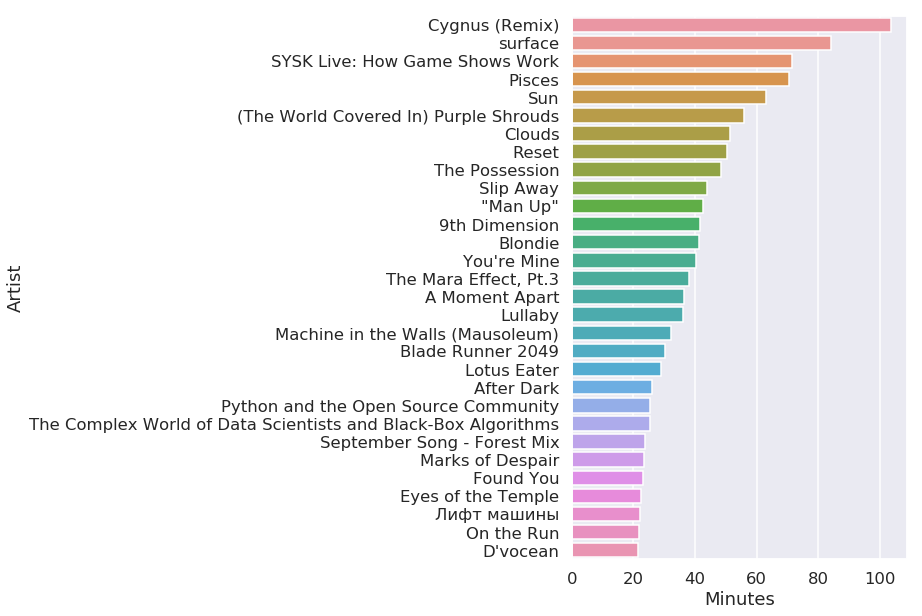

In [25]:
fig = plt.figure(figsize=(6,10))
ax = plt.subplot(111)
data = history_df.groupby('trackName')['minPlayed'].sum().sort_values(ascending=False)[:30]
x = data.index
y = data.values
sns.barplot(y,x, orient="h", ax = ax)
ax.set_xlabel('Minutes')
ax.set_ylabel('Artist')